In [ ]:
#|default_exp vision.data
#|default_cls_lvl 3

In [ ]:
#|export
from __future__ import annotations

from fastcore.transform import DisplayedTransform

from fastai.data.block import TransformBlock
from fastai.data.transforms import IntToFloatTensor
from fastai.vision.core import PILBase, PILImage, PILMask, TensorPoint, TensorBBox, AddMaskCodes

from fastxtend.imports import *

# Vision Data

> Additional helper functions to get data in a `DataLoaders` in vision applications

In [ ]:
#|hide
from nbdev.showdoc import *

## Batch Transforms on CPU

With enough DataLoader workers and fast CPU cores, using fastai's GPU augmentations can lead to slower training then using CPU augmentations.

`ImageCPUBlock` and `MaskCPUBlock` are convenience methods for executing fastai batch transforms on CPU.

## CPU Batch Transform Helpers - 

In [ ]:
#|export
class PreBatchAsItem(DisplayedTransform):
    "Converts Tensor from CHW to BCHW by adding a fake B dim"
    order=11
    def encodes(self, x:TensorImage|TensorMask|TensorPoint|TensorBBox):
        return x.unsqueeze(0)
    def decodes(self, x:TensorImage|TensorMask|TensorPoint|TensorBBox):
        return x.squeeze(0)

In [ ]:
#|export
class PostBatchAsItem(DisplayedTransform):
    "Converts Tensor from BCHW to CHW by removing the fake B dim"
    order=98
    def encodes(self, x:TensorImage|TensorMask|TensorPoint|TensorBBox):
        return x.squeeze(0)
    def decodes(self, x:TensorImage|TensorMask|TensorPoint|TensorBBox):
        return x.unsqueeze(0)

PyTorch 2D image transforms expect tensors to be in BCHW format. `PreBatchAsItem` and `PostBatchAsItem` add and remove a B dim to a single Tensor Image so fastai batch transforms will work on individual items.

## CPU Batch Blocks - 

In [ ]:
#|export
def ImageCPUBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls` for running batch_tfms on CPU"
    return TransformBlock(type_tfms=cls.create, 
                          item_tfms=[IntToFloatTensor, PreBatchAsItem, PostBatchAsItem])

In [ ]:
#|export
def MaskCPUBlock(codes:listy|None=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`, for running batch_tfms on CPU"
    return TransformBlock(type_tfms=PILMask.create, 
                          item_tfms=[AddMaskCodes(codes=codes), IntToFloatTensor, PreBatchAsItem, PostBatchAsItem])

### Batch Transforms on CPU Example

In [ ]:
#|hide
from fastcore.basics import num_cpus

from fastai.data.external import URLs, untar_data
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import GrandparentSplitter, get_image_files, parent_label, Normalize
from fastai.vision.augment import aug_transforms
from fastai.vision.core import imagenet_stats

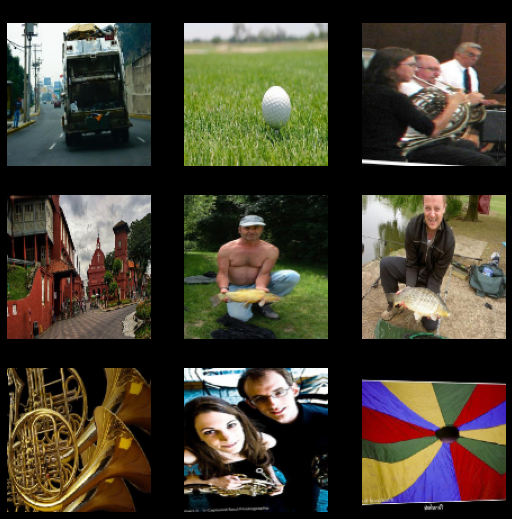

In [ ]:
#|slow
with no_random():
    imagenette = untar_data(URLs.IMAGENETTE_320)

    dblock = DataBlock(blocks=(ImageCPUBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=aug_transforms(size=128),
                        batch_tfms=Normalize.from_stats(*imagenet_stats))
    dls =  dblock.dataloaders(imagenette, bs=9, num_workers=num_cpus())

    dls.show_batch()